In [1]:
import pandas as pd
import sqlalchemy
import geopandas as gpd
import seaborn as sns
from shapely import wkt
from itertools import cycle, islice

C:\Users\Modeller\AppData\Local\anaconda3\envs\summary\lib\site-packages\geopandas\_compat.py:115: UserWarning: The Shapely GEOS version (3.11.4-CAPI-1.17.4) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
df = pd.read_csv(r'..\..\..\outputs\network\network_results.csv')

# Congested network components by time of day
df.columns

# Get freeflow from 20to5 period

# Exclude trips taken on non-designated facilities (facility_type == 0)
# These are artificial (weave lanes to connect HOV) or for non-auto uses 
df = df[df['data3'] != 0]    # data3 represents facility_type

# calculate total link VMT and VHT
df['VMT'] = df['@tveh']*df['length']
df['VHT'] = df['@tveh']*df['auto_time']/60

# Define facility type
df.loc[df['data3'].isin([1,2]), 'facility_type'] = 'highway'
df.loc[df['data3'].isin([3,4,6]), 'facility_type'] = 'arterial'
df.loc[df['data3'].isin([5]), 'facility_type'] = 'connector'

# Calculate delay
# Select links from overnight time of day
delay_df = df.loc[df['tod'] == '20to5'][['ij','auto_time']]
delay_df.rename(columns={'auto_time':'freeflow_time'}, inplace=True)

# Merge delay field back onto network link df
df = pd.merge(df, delay_df, on='ij', how='left')

# Calcualte hourly delay
df['total_delay'] = ((df['auto_time']-df['freeflow_time'])*df['@tveh'])/60    # sum of (volume)*(travtime diff from freeflow)

# Calcualte speed as a percent of freeflow
df['flow_index'] = df['auto_time']/df['freeflow_time']

df['county'] =df['@countyid'].map({33: 'King',
                                      35: 'Kitsap',
                                      53: 'Pierce',
                                      61: 'Snohomish'})

df['speed'] = df['length']/df['auto_time']*60
df['congestion_index'] = df['speed']/df['data2']
df['congestion_index'] = df['congestion_index'].clip(0,1)
df['congestion_category'] = pd.cut(df['congestion_index'], bins=[0,.25,.5,.7,1], labels=['Severe','Heavy','Moderate','Light'])

In [3]:
def read_from_sde(connection_string, feature_class_name, version,
                  crs={'init': 'epsg:2285'}, is_table = False):
    """
    Returns the specified feature class as a geodataframe from ElmerGeo.
    
    Parameters
    ----------
    connection_string : SQL connection string that is read by geopandas 
                        read_sql function
    
    feature_class_name: the name of the featureclass in PSRC's ElmerGeo 
                        Geodatabase
    
    cs: cordinate system
    """


    engine = sqlalchemy.create_engine(connection_string)
    con=engine.connect()
    #con.execute("sde.set_current_version {0}".format(version))
    if is_table:
        gdf=pd.read_sql('select * from %s' % 
                   (feature_class_name), con=con)
        con.close()

    else:
        df=pd.read_sql('select *, Shape.STAsText() as geometry from %s' % 
                   (feature_class_name), con=con)
        con.close()

        df['geometry'] = df['geometry'].apply(wkt.loads)
        gdf=gpd.GeoDataFrame(df, geometry='geometry')
        gdf.crs = crs
        cols = [col for col in gdf.columns if col not in 
                ['Shape', 'GDB_GEOMATTR_DATA', 'SDE_STATE_ID']]
        gdf = gdf[cols]
    
    return gdf


In [4]:
def format_df(df, col_list, col_name, index_list, index_name):
    
    # Re-order columns
    df = df[col_list]
    # Re-order index
    df = df.reindex(index_list)
    # Set visible column and index names
    df.columns.name = col_name
    df.index.name = index_name
    
    return df


In [5]:
# set chart style
sns.set_style("dark")
sns.set_context("notebook", font_scale=1.5, 
                rc={"lines.linewidth": 1.5})
colors = ['#91268F','#F05A28','#8CC63E','#00A7A0','#4C4C4C', '#BFE9E7']
sns.set(font="Pragmatica Condensed Light")

In [6]:
# Load regional geographies layer to intersect with network shapefile
connection_string = 'mssql+pyodbc://AWS-PROD-SQL\Sockeye/ElmerGeo?driver=SQL Server?Trusted_Connection=yes'
crs = {'init' : 'EPSG:2285'}
version = "'DBO.Default'"
gdf_shp = read_from_sde(connection_string, 'regional_geographies_preferred_alternative', version, crs=crs, is_table=False)

# Intersect geography this with the network shapefile
gdf_network = gpd.read_file(r'..\..\..\inputs\scenario\networks\shapefiles\AM\AM_edges.shp')
gdf_intersect = gpd.overlay(gdf_network, gdf_shp, how="union", keep_geom_type=False)

# Will need to relaculate the lengths since some were split across the regional geographies
gdf_intersect['new_length'] = gdf_intersect.geometry.length/5280.0

### IMPORTANT
# filter out the polygon results and only keep lines
gdf_intersect = gdf_intersect[gdf_intersect.geometry.type.isin(['MultiLineString','LineString'])]

C:\Users\Modeller\AppData\Local\anaconda3\envs\summary\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [7]:
df = df[['@tveh','congestion_category','i_node','j_node','length','tod']].merge(gdf_intersect, 
                                                             left_on=['i_node','j_node'],
                                                            right_on=['i','j'],
                                                                  how='left')
df['VMT'] = df['new_length']*df['@tveh']

# Congestion by Regional Geography
### Total VMT & Percent of VMT by Congestion Level

- **Severe: < 25% Speed Limit** (e.g., less than 15 mph on a road with speed limit of 60 mph)
- **Heavy: 25-50% Speed Limit** (e.g., 15-30 mph on a road with speed limit of 60 mph)
- **Moderate: 50-70% Speed Limit** (e.g, 30-42 mph on a road with speed limit of 60 mph)

#### All Day

In [8]:
rg_list = ['Metro', 'Core', 'HCT', 'CitiesTowns', 'UU', 'Rural']

In [9]:
# Percent of VMT by congestion category
pd.options.display.float_format = '{:0,.0f}'.format
_df = df.pivot_table(index='congestion_category',columns='rg_propose_pa',
               aggfunc='sum',values='VMT')
_df = format_df(_df, rg_list, None, ['Light','Moderate','Heavy','Severe'], None)
_df 

,Metro,Core,HCT,CitiesTowns,UU,Rural
Light,"17,128,546","19,700,816","12,260,148","4,182,086","3,212,426","14,120,446"
Moderate,"2,622,958","2,522,518","1,486,867","393,392","253,025","476,798"
Heavy,"1,278,202","1,215,385","707,122","162,967","94,786","242,479"
Severe,"134,541","134,282","58,058","11,711","7,744","37,630"


In [10]:
pd.options.display.float_format = '{:0,.1%}'.format
_df = _df/_df.sum(axis=0)
_df

,Metro,Core,HCT,CitiesTowns,UU,Rural
Light,80.9%,83.6%,84.5%,88.0%,90.0%,94.9%
Moderate,12.4%,10.7%,10.2%,8.3%,7.1%,3.2%
Heavy,6.0%,5.2%,4.9%,3.4%,2.7%,1.6%
Severe,0.6%,0.6%,0.4%,0.2%,0.2%,0.3%


findfont: Font family ['Pragmatica Condensed Light'] not found. Falling back to DejaVu Sans.


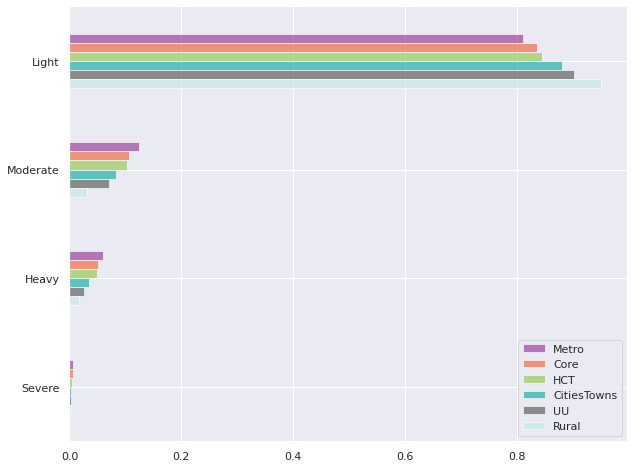

In [11]:
my_colors = list(islice(cycle(colors), None, len(_df)))
ax = _df.plot(kind='barh', alpha=0.6, color=colors, figsize=(10,8))
ax.invert_yaxis()
ax.legend(loc='lower right');

#### AM Peak (7 to 8 AM)

In [12]:
pd.options.display.float_format = '{:0,.0f}'.format
df_am = df[df['tod'] == '7to8']
_df = df.pivot_table(index='congestion_category',columns='rg_propose_pa',
               aggfunc='sum',values='VMT')
_df = format_df(_df, rg_list, None, ['Light','Moderate','Heavy','Severe'], None)
_df 

,Metro,Core,HCT,CitiesTowns,UU,Rural
Light,"17,128,546","19,700,816","12,260,148","4,182,086","3,212,426","14,120,446"
Moderate,"2,622,958","2,522,518","1,486,867","393,392","253,025","476,798"
Heavy,"1,278,202","1,215,385","707,122","162,967","94,786","242,479"
Severe,"134,541","134,282","58,058","11,711","7,744","37,630"


In [13]:
pd.options.display.float_format = '{:0,.1%}'.format
_df = _df/_df.sum(axis=0)
_df

,Metro,Core,HCT,CitiesTowns,UU,Rural
Light,80.9%,83.6%,84.5%,88.0%,90.0%,94.9%
Moderate,12.4%,10.7%,10.2%,8.3%,7.1%,3.2%
Heavy,6.0%,5.2%,4.9%,3.4%,2.7%,1.6%
Severe,0.6%,0.6%,0.4%,0.2%,0.2%,0.3%


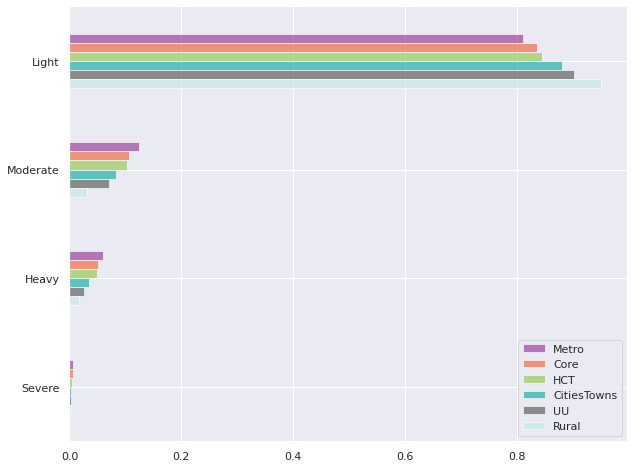

In [14]:
my_colors = list(islice(cycle(colors), None, len(_df)))
ax = _df.plot(kind='barh', alpha=0.6, color=colors, figsize=(10,8))
ax.invert_yaxis()
ax.legend(loc='lower right');

#### PM Peak (5 to 6 PM)

In [15]:
pd.options.display.float_format = '{:0,.0f}'.format
df_am = df[df['tod'] == '17to18']
_df = df.pivot_table(index='congestion_category',columns='rg_propose_pa',
               aggfunc='sum',values='VMT')
_df = format_df(_df, rg_list, None, ['Light','Moderate','Heavy','Severe'], None)
_df 

,Metro,Core,HCT,CitiesTowns,UU,Rural
Light,"17,128,546","19,700,816","12,260,148","4,182,086","3,212,426","14,120,446"
Moderate,"2,622,958","2,522,518","1,486,867","393,392","253,025","476,798"
Heavy,"1,278,202","1,215,385","707,122","162,967","94,786","242,479"
Severe,"134,541","134,282","58,058","11,711","7,744","37,630"


In [16]:
pd.options.display.float_format = '{:0,.1%}'.format
_df = _df/_df.sum(axis=0)
_df

,Metro,Core,HCT,CitiesTowns,UU,Rural
Light,80.9%,83.6%,84.5%,88.0%,90.0%,94.9%
Moderate,12.4%,10.7%,10.2%,8.3%,7.1%,3.2%
Heavy,6.0%,5.2%,4.9%,3.4%,2.7%,1.6%
Severe,0.6%,0.6%,0.4%,0.2%,0.2%,0.3%


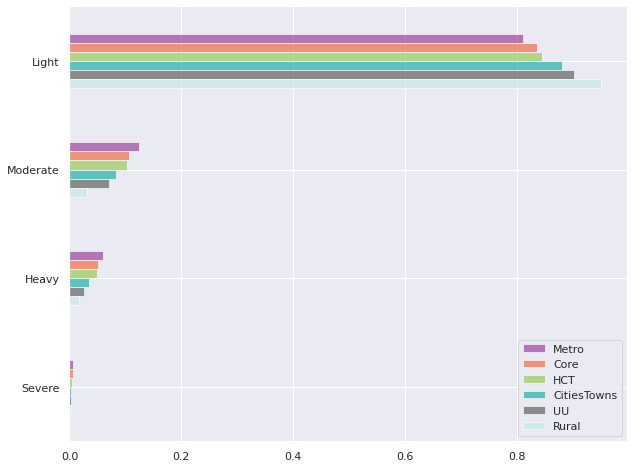

In [17]:
my_colors = list(islice(cycle(colors), None, len(_df)))
ax = _df.plot(kind='barh', alpha=0.6, color=colors, figsize=(10,8))
ax.invert_yaxis()
ax.legend(loc='lower right');